### Experiments with training spectral bias

Imports

In [35]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import random
import torch.nn as nn
import torch.optim as optim
import heapq
import os
from datetime import datetime
import argparse
import torch.nn.functional as F

Set save to True if you want to save plots

In [36]:
save = True

Only for python script: uncomment if running on cluster

In [37]:
# These are both placeholders
num_epochs = 1000
model_name = 'f0'

In [38]:
# # Parse command-line arguments
# parser = argparse.ArgumentParser(description='Train a neural network model')
# parser.add_argument('--epochs', type=int, default=1000, help='Number of training epochs')
# parser.add_argument('--model_name', type=str, default='model', help='Name of the saved model')
# args = parser.parse_args()

# # Use the parsed arguments
# num_epochs = args.epochs
# model_name = args.model_name

Check if CUDA is available

In [39]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [40]:
# For reproducibility
seed = 42

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(seed)

**Simplified function generation**

In [41]:
def generate_freq_dataset(num_samples, num_points, min_freq, max_freq):
    x = torch.linspace(0, 2 * np.pi, num_points, requires_grad=True)
    functions = []
    derivatives = []
    
    for _ in range(num_samples):
        # The number of different frequency components will be between 1 and 10
        num_freqs = torch.randint(1, 10, (1,)).item()
        amplitudes = torch.rand(num_freqs * 2)  # Double the number of amplitudes (between 0 and 1)
        frequencies = torch.randint(min_freq, max_freq + 1, (num_freqs,)).float()
        phases = torch.rand(num_freqs * 2) * 2 * np.pi  # Double the number of phases
        
        y = sum(a * torch.sin(f * x + p) for a, f, p in zip(amplitudes[:num_freqs], frequencies, phases[:num_freqs])) + \
            sum(a * torch.cos(f * x + p) for a, f, p in zip(amplitudes[num_freqs:], frequencies, phases[num_freqs:]))
        
        dy_dx = torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y), create_graph=True)[0]
        
        functions.append(y.detach().numpy())
        derivatives.append(dy_dx.detach().numpy())
    
    return np.array(functions), np.array(derivatives)

## Generate datasets

In [42]:
num_samples = 500
num_points = 1000
batch_size = 32

low_freq_functions, low_freq_derivatives = generate_freq_dataset(num_samples, num_points, 1, 5)
general_freq_functions, general_freq_derivatives = generate_freq_dataset(num_samples, num_points, 1, 10)
high_freq_functions, high_freq_derivatives = generate_freq_dataset(num_samples, num_points, 6, 10)

low_freq_dataset = TensorDataset(torch.tensor(low_freq_functions), torch.tensor(low_freq_derivatives))
general_freq_dataset = TensorDataset(torch.tensor(general_freq_functions), torch.tensor(general_freq_derivatives))
high_freq_dataset = TensorDataset(torch.tensor(high_freq_functions), torch.tensor(high_freq_derivatives))

low_freq_dataloader = DataLoader(TensorDataset(torch.tensor(low_freq_functions), torch.tensor(low_freq_derivatives)), batch_size=batch_size, shuffle=True)
high_freq_dataloader = DataLoader(TensorDataset(torch.tensor(high_freq_functions), torch.tensor(high_freq_derivatives)), batch_size=batch_size, shuffle=True)
general_freq_dataloader = DataLoader(TensorDataset(torch.tensor(general_freq_functions), torch.tensor(general_freq_derivatives)), batch_size=batch_size, shuffle=True)

In [43]:
total_size = len(low_freq_dataset)
train_size = int(0.8 * total_size)
test_size = total_size - train_size
generator = torch.Generator().manual_seed(seed)

# low freq
train_dataset_l, test_dataset_l = random_split(low_freq_dataset, [train_size, test_size], generator=generator)
train_dataloader_l = DataLoader(train_dataset_l, batch_size=32, shuffle=True, drop_last=True)
test_dataloader_l = DataLoader(test_dataset_l, batch_size=32, shuffle=False, drop_last=True)

# general freq
train_dataset_g, test_dataset_g = random_split(general_freq_dataset, [train_size, test_size], generator=generator)
train_dataloader_g = DataLoader(train_dataset_g, batch_size=32, shuffle=True, drop_last=True)
test_dataloader_g = DataLoader(test_dataset_g, batch_size=32, shuffle=False, drop_last=True)

# high freq
train_dataset_h, test_dataset_h = random_split(high_freq_dataset, [train_size, test_size], generator=generator)
train_dataloader_h = DataLoader(train_dataset_h, batch_size=32, shuffle=True, drop_last=True)
test_dataloader_h = DataLoader(test_dataset_h, batch_size=32, shuffle=False, drop_last=True)


## Plot random function from one of the datasets

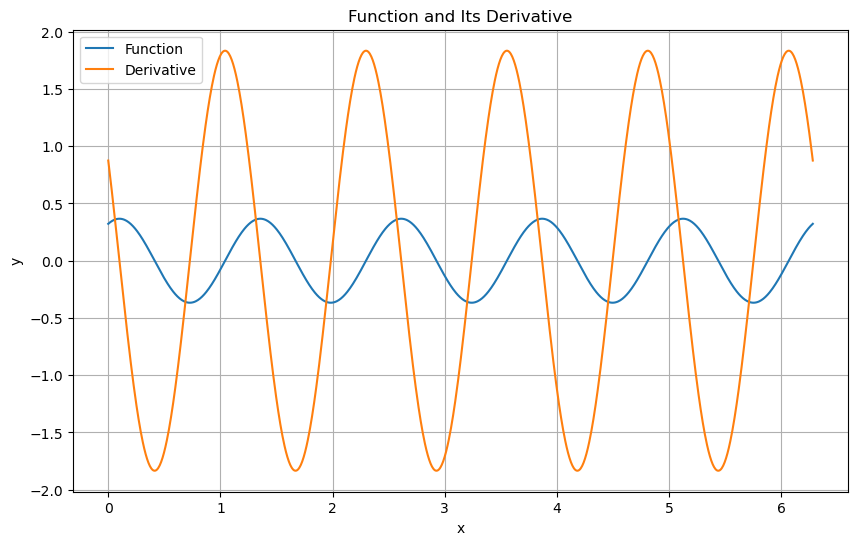

In [44]:
a = np.random.randint(32)

fun, deriv = next(iter(low_freq_dataloader))

first_function = fun[a]
first_derivative = deriv[a]

# Generate x values corresponding to the function inputs
x_values = np.linspace(0, 2 * np.pi, 1000)

# Plotting the function and its derivative
plt.figure(figsize=(10, 6))
plt.plot(x_values, first_function, label='Function')
plt.plot(x_values, first_derivative, label='Derivative')
plt.title('Function and Its Derivative')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

## Miscellaneous plotting functions

In [45]:
def plot_losses(train_losses, test_losses, save_dir='plots', filename=None, save=False):
    if not train_losses:
        return
    
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    current_date = datetime.now().strftime("%m-%d")
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, linestyle='-', color='b', label='Training Loss')
    plt.plot(epochs, test_losses, linestyle='-', label='Test Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.yscale('log')  # Set the y-axis to logarithmic scale
    plt.legend()
    plt.grid(True)
    filename = f"{filename}_{current_date}.png"
    save_path = os.path.join(save_dir, filename)
    if save:
        plt.savefig(save_path)    
    plt.show()

In [46]:
def plot_output(model1, dataset, order=None, save_dir='plots', filename=None, save=False): 
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    current_date = datetime.now().strftime("%m-%d")
    model1.eval()  # Set the model to evaluation mode

    train_dataloader_viz = get_random_function(dataset, shuffle=True)
    # Get a random sample from the dataloader
    dataiter = iter(train_dataloader_viz)
    function, true_derivative = next(dataiter)

    # Reshape the input for the model
    function = function.unsqueeze(1)  # Add channel dimension

    # Make prediction
    with torch.no_grad():
        if order == 1 or order == 2:
            predicted_derivative = model1(function)
        
        if order == 'rollout':
            predicted_derivative = model1(function)
            predicted_derivative = model1(predicted_derivative)

    # Convert tensors to numpy arrays for plotting
    x = torch.linspace(0, 2*torch.pi, 1000).numpy()
    function = function.squeeze().numpy()

    predicted_derivative = predicted_derivative.squeeze().numpy()

    true_derivative = true_derivative.squeeze().numpy()

    # Plot the results
    plt.figure(figsize=(12, 6))

    plt.plot(x, function, label='Original Function', color='blue')
    if order == 1:
        plt.plot(x, true_derivative, label=f'True {order}st derivative')

    plt.plot(x[10:-10], predicted_derivative[10:-10], label=f'Predicted {order}nd Derivative', linestyle='--')

    plt.title('Function, True Derivatives, and Predicted Derivatives')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    filename = f"{filename}_{current_date}.png"

    save_path = os.path.join(save_dir, filename)
    if save:
        plt.savefig(save_path)  
    plt.show()

In [47]:
def get_random_function(dataset, shuffle=True):
    return DataLoader(dataset, batch_size=1, shuffle=shuffle)

## Function to train model

In [48]:
criterion = nn.MSELoss()

In [49]:
train_losses, test_losses = [], []

def model_training(model, train_dataloader, test_dataloader, num_epochs,\
    split_freq=None, filename=None, save=None, order=None):
    train_losses = []
    test_losses = []

    low_freq_nmses = []
    general_freq_nmses = []
    high_freq_nmses = []
    epoch_list = []

    lr = 1e-3

    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        test_loss = 0.0

        if epoch % split_freq == 0:
            l, g, h = print_and_store_metrics(model)
            low_freq_nmses.append(l)
            general_freq_nmses.append(g)
            high_freq_nmses.append(h)
            epoch_list.append(epoch)

        for batch_functions, batch_derivatives in train_dataloader:
            batch_functions = batch_functions.unsqueeze(1)
            batch_derivatives = batch_derivatives.unsqueeze(1)

            outputs = model(batch_functions)
            loss = criterion(outputs, batch_derivatives)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_dataloader)

        model.eval()
        with torch.no_grad():
            for b_test_functions, b_test_derivatives in test_dataloader:
                b_test_functions = b_test_functions.unsqueeze(1)
                b_test_derivatives = b_test_derivatives.unsqueeze(1)

                test_outputs = model(b_test_functions)
                batch_test_loss = criterion(test_outputs, b_test_derivatives)

                test_loss += batch_test_loss.item()

        test_loss /= len(test_dataloader)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

    print(f"Training finished for {order}st derivative")

    plt.figure(figsize=(10, 6))
    plt.plot(epoch_list, low_freq_nmses, label='Low freq NMSE')
    plt.plot(epoch_list, general_freq_nmses, label='General freq NMSE')
    plt.plot(epoch_list, high_freq_nmses, label='High freq NMSE')

    # Adding labels and title
    plt.xlabel('Epoch')
    plt.ylabel('NMSE')
    plt.yscale('log')
    plt.title('NMSEs of different frequencies during training')
    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.show()
    if save:
        plt.savefig(filename)  

    return train_losses, test_losses

## Metric functions

In [50]:
def compute_mse(dataloader, model):
    """
    Takes in a dataloader and a model to compute MSE.
    """

    model.eval()
    all_outputs = []
    all_targets = []

    for function, deriv in dataloader:
        function = function.unsqueeze(1)
        deriv = deriv.unsqueeze(1)

        # Compute model output
        model_output = model(function)
        all_targets.append(deriv)

        # Collect outputs
        all_outputs.append(model_output)

    # Concatenate all collected outputs and targets
    all_outputs = torch.cat(all_outputs, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    # Compute MSE
    mse = torch.mean((all_targets - all_outputs) ** 2)
    nmse = mse / torch.mean(all_targets ** 2)

    return mse.item(), nmse.item()

criterion = torch.nn.MSELoss()

In [51]:
def print_and_store_metrics(f0):
    return compute_mse(test_dataloader_l, f0)[1], compute_mse(test_dataloader_g, f0)[1], compute_mse(test_dataloader_h, f0)[1]

In [52]:
def print_metrics(model):
    print(f"NMSE over low freq test functions: {compute_mse(test_dataloader_l, model)[1]}")
    print(f"NMSE over general freq test functions: {compute_mse(test_dataloader_g, model)[1]}")
    print(f"NMSE over high freq test functions: {compute_mse(test_dataloader_h, model)[1]}")



## Create models

In [53]:
# simple 1D CNN
class SimpleCNN(nn.Module):
    def __init__(self, n_layers=3, kernel_size=3, hidden_size=64):
        super(SimpleCNN, self).__init__()
        # Parameters
        self.n_layers = n_layers
        self.kernel_size = kernel_size
        self.hidden_size = hidden_size

        # Model
        self.convs = nn.ModuleList()
        if n_layers == 1:
            self.convs.append(nn.Conv1d(1, 1, kernel_size=kernel_size, padding=kernel_size//2))
        elif n_layers >= 2:
            self.convs.append(nn.Conv1d(1, hidden_size, kernel_size=kernel_size, padding=kernel_size//2))
            for _ in range(n_layers - 2):
                self.convs.append(nn.Conv1d(hidden_size, hidden_size, kernel_size=kernel_size, padding=kernel_size//2))
            self.convs.append(nn.Conv1d(hidden_size, 1, kernel_size=kernel_size, padding=kernel_size//2))
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, x):
        for i, conv in enumerate(self.convs):
            if i < len(self.convs) - 1:
                x = self.relu(conv(x))
            else:
                x = conv(x)
        return x

In [54]:
set_seed(seed)
L3ModelK3 = SimpleCNN(n_layers=3, kernel_size=3)

In [55]:
# train_losses, test_losses = model_training(L3ModelK3, train_dataloader_g, test_dataloader_g,\
#     num_epochs=1000, split_freq=10, filename='../plots/spectral_bias/f0_E2000_phased_training',\
#     save=save, order='first')
# plot_losses(train_losses, test_losses, save_dir='../plots/spectral_bias', filename='f0_E2000_phased_training', save=save)

## Plot results

In [56]:
def plot_all_outputs(model, model_name):
    plot_output(model, dataset=test_dataset_l, order=1, save_dir='../plots/spectral_bias', filename=f'{model_name}_E{num_epochs}_lf_output', save=save)
    plot_output(model, dataset=test_dataset_g, order=1, save_dir='../plots/spectral_bias', filename=f'{model_name}_E{num_epochs}_lf_output', save=save)
    plot_output(model, dataset=test_dataset_h, order=1, save_dir='../plots/spectral_bias', filename=f'{model_name}_E{num_epochs}_lf_output', save=save)

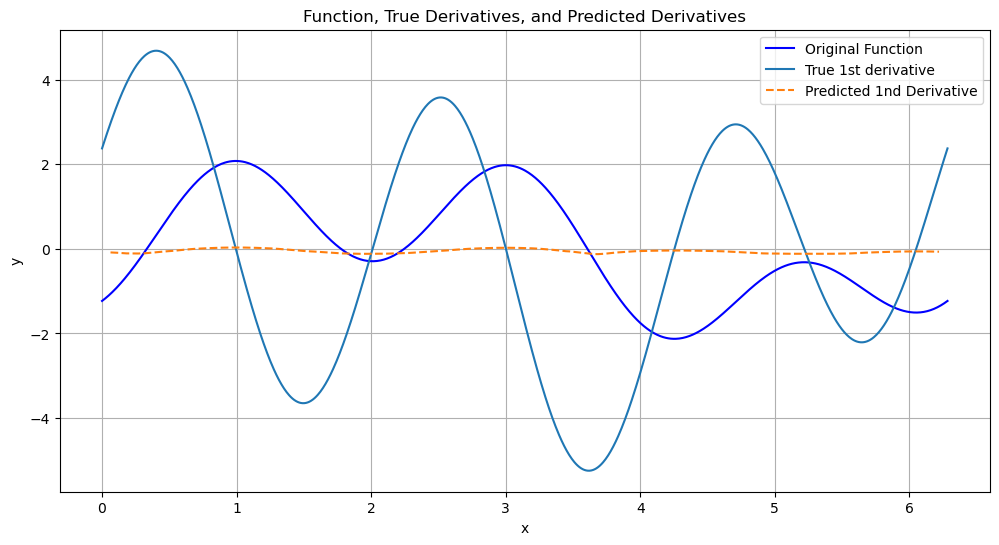

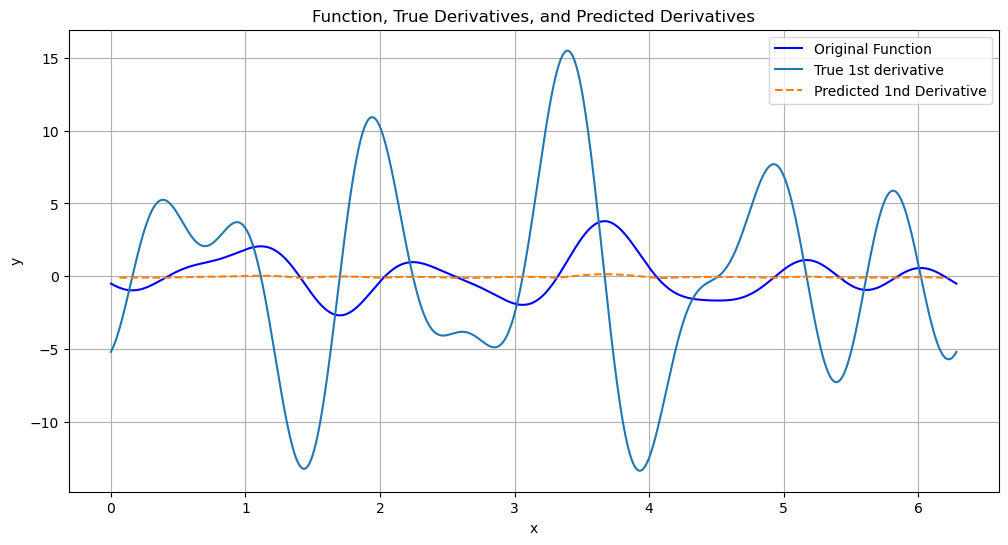

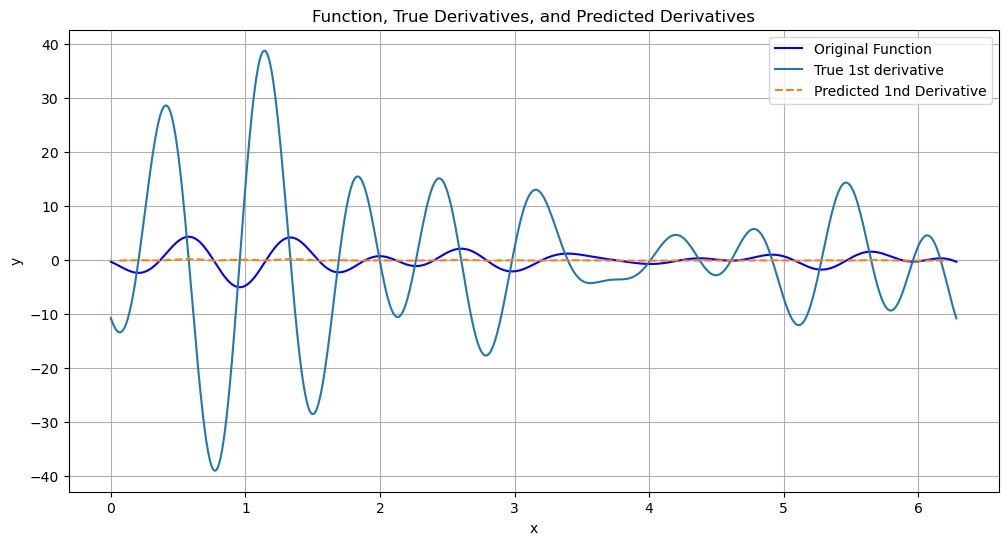

In [57]:
plot_all_outputs(L3ModelK3, model_name = 'L3ModelK3')

In [58]:
print_metrics(L3ModelK3)

NMSE over low freq test functions: 0.9994839429855347
NMSE over general freq test functions: 0.9992568492889404
NMSE over high freq test functions: 0.999252438545227


In [59]:
print(L3ModelK3)

SimpleCNN(
  (convs): ModuleList(
    (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (2): Conv1d(64, 1, kernel_size=(3,), stride=(1,), padding=(1,))
  )
  (relu): ReLU()
  (tanh): Tanh()
)


## Color map plots

In [60]:
def compute_fft_and_max_freq(dataloader, deriv=False, model=None, residue=False):
    fft_amplitudes = []
    max_frequencies = []
    T = 2 * torch.pi
    N = 1000

    # The spacing is T / N, i.e. 2pi/1000, but since we interpret f(x)=sin(5x) to
    # have a frequency of 5 over the domain x=[0,2pi], then we scale up by 2pi 
    # to get the unit cycle back to 1
    frequencies = torch.fft.fftfreq(N, T / N) * T
    positive_freq_indices = frequencies >= 0
    positive_freqs = frequencies[positive_freq_indices]

    plot_type = ''

    # Iterate over each batch
    for functions, derivatives in dataloader:  # Note that derivatives are ignored in this loop
        
        if deriv and not model and not residue: # If you only want the derivative
            functions = derivatives
            F = torch.fft.fft(functions)
            plot_type = "ground truth u_g'"
            
            
        elif not deriv and model and not residue: # If you only want the model output
            functions = model(functions.unsqueeze(1)).squeeze()
            F = torch.fft.fft(functions)
            plot_type = 'model output f(u_g)'

            # output = model(functions)
            
            # output = output.squeeze()
            # functions = output # set this so that the FFTs can be computed in the next line
        
        elif residue and model: # If you only want the residue
            
            functions = functions.unsqueeze(1)
            outputs = model(functions).squeeze()
            F_outputs = torch.fft.fft(outputs)

            F_derivatives = torch.fft.fft(derivatives)

            residues = F_derivatives - F_outputs
            
            # print(f"shape of F_derivaives: {F_derivatives.shape}")
            # normalizing = F_derivatives.norm(p=2, dim=1, keepdim=True) ** 2 / F_derivatives.shape[1]
            # print(f"shape of normalizing: {normalizing}")
            # residues = residues / normalizing

            plot_type = 'spectral error'
            F = residues
            # print(f"F is: {F}")

        else:
            plot_type = 'ground truth u_g'
            F = torch.fft.fft(functions)

        # else: # If you only want the original function u_g
        magnitudes = torch.abs(F) / N

        # Consider only positive frequencies
        positive_magnitudes = magnitudes[:, positive_freq_indices]

        fft_amplitudes.append(positive_magnitudes)
        
        # Maximum frequency based on the highest amplitude for each function in the batch
        max_indices = torch.argmax(positive_magnitudes, dim=1)
        batch_max_freqs = positive_freqs[max_indices]
        max_frequencies.extend(batch_max_freqs)
        print(f"Plotting {plot_type}")

    return torch.vstack(fft_amplitudes), torch.tensor(max_frequencies), positive_freqs, plot_type

def plot_heatmap(fft_amplitudes, max_frequencies, freqs, fun_type, xmin=0, xmax=0,\
    first=False, sorted_indices=None):

    fft_amplitudes = fft_amplitudes.detach().numpy()
    max_frequencies = max_frequencies.detach().numpy()
    freqs = freqs.detach().numpy()

    
    if first:
    # Sort functions by dominant frequency
        sorted_indices = np.argsort(-max_frequencies)  # Sort in descending order
        sorted_fft = fft_amplitudes[sorted_indices]
    else:
        print("Using predefined sort")
        sorted_fft = fft_amplitudes[sorted_indices]

    plt.figure(figsize=(10, 6))
    im = plt.imshow(sorted_fft, aspect='auto', extent=[freqs[0], freqs[-1], 0, len(sorted_fft)],\
        interpolation='nearest')

    plt.colorbar(im, label='Amplitude')
    plt.xlabel('Frequency (rad/s)')
    plt.ylabel('Function Index (sorted by max frequency)')
    plt.title(f'FFT Amplitude Heatmap for {fun_type}')
    plt.xlim([xmin, xmax])
    plt.show()

    if first:
        return sorted_indices


## Training function

In [61]:
train_losses, test_losses = [], []

def model_training_plots(model, train_dataloader, test_dataloader, num_epochs,\
    split_freq=None, filename=None, save=None, order=None, nmse=False,\
        deriv=None, residue=False, lr=1e-3, heatmap=True):
    train_losses = []
    test_losses = []

    low_freq_nmses = []
    general_freq_nmses = []
    high_freq_nmses = []
    epoch_list = []

    lr = lr
    optimizer = optim.Adam(model.parameters(), lr=lr)

    criterion = nn.MSELoss()
    # If nmse, then use NMSE as loss
    if nmse:
        def criterion(target, output, nmse=None):
            mse = torch.mean((target - output) ** 2)
            mse = mse / torch.mean(target ** 2)
            
            return mse
    
    num_plots = split_freq
    split_freq = num_epochs // split_freq
    print(split_freq)

    # At the first epoch, compute the order of the functions before training
    sorted_indices = plot_heatmaps(label=f'first', all=False, first=True)
    plt.show()

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        test_loss = 0.0

        for batch_functions, batch_derivatives in train_dataloader:
            batch_functions = batch_functions.unsqueeze(1)
            batch_derivatives = batch_derivatives.unsqueeze(1)

            outputs = model(batch_functions)
            loss = criterion(outputs, batch_derivatives)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_dataloader)

        model.eval()
        with torch.no_grad():
            for b_test_functions, b_test_derivatives in test_dataloader:
                b_test_functions = b_test_functions.unsqueeze(1)
                b_test_derivatives = b_test_derivatives.unsqueeze(1)

                test_outputs = model(b_test_functions)
                batch_test_loss = criterion(test_outputs, b_test_derivatives)
                

                test_loss += batch_test_loss.item()

        test_loss /= len(test_dataloader)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

        # If iteration reached, then plot the colormap once
        if heatmap:
            if (epoch) % split_freq == 0:
                print(f"Plotting the colormap once at iteration {epoch}")
                label = epoch // split_freq

                l, g, h = print_and_store_metrics(model)
                low_freq_nmses.append(l)
                general_freq_nmses.append(g)
                high_freq_nmses.append(h)
                epoch_list.append(epoch)

                # First is false here, but we pass in
                plot_heatmaps(model=model, label=f'{label}', all=False,\
                    deriv=deriv, residue=residue, epoch=epoch, sorted_indices=sorted_indices)

                plt.show()

    print(f"Training finished for {order}st derivative")

    plt.figure(figsize=(10, 6))
    plt.plot(epoch_list, low_freq_nmses, label='Low freq NMSE')
    plt.plot(epoch_list, general_freq_nmses, label='General freq NMSE')
    plt.plot(epoch_list, high_freq_nmses, label='High freq NMSE')

    # Adding labels and title
    plt.xlabel('Epoch')
    plt.ylabel('NMSE')
    plt.yscale('log')

    plt.title('NMSEs of different frequencies during training')
    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.show()
    if save:
        plt.savefig(filename)  

    return train_losses, test_losses

## Changing model depth

In [62]:
def train_varying_kernel_size(kernel_sizes, train_dataloader, test_dataloader, num_epochs,\
    seed, split_freq=None, filename=None, save=None, save_model=False, order=None):
    
    set_seed(seed)
    
    all_train_losses = []
    all_test_losses = []

    general_freq_nmse_dict = {}
    low_freq_nmse_dict = {}
    high_freq_nmse_dict = {}

    epoch_list = []

    avg_gen_nmse_last_50_epochs = np.zeros(len(kernel_sizes))
    avg_low_nmse_last_50_epochs = np.zeros(len(kernel_sizes))
    avg_high_nmse_last_50_epochs = np.zeros(len(kernel_sizes))

    lr = 1e-3

    for i, kernel_size in enumerate(kernel_sizes):
        # Set the seed each time we increase the num of layers in the model
        set_seed(seed)
        model = SimpleCNN(n_layers=3, kernel_size=kernel_size)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        
        train_losses = []
        test_losses = []
        general_freq_nmses = []
        low_freq_nmses = []
        high_freq_nmses = []

        for epoch in range(num_epochs):
            model.train()
            train_loss = 0.0
            test_loss = 0.0

            # Calculate the metrics at every iteration
            l, g, h = print_and_store_metrics(model)
            general_freq_nmses.append(g)
            low_freq_nmses.append(l)
            high_freq_nmses.append(h)

            epoch_list.append(epoch)

            for batch_functions, batch_derivatives in train_dataloader:
                batch_functions = batch_functions.unsqueeze(1)
                batch_derivatives = batch_derivatives.unsqueeze(1)

                outputs = model(batch_functions)
                loss = criterion(outputs, batch_derivatives)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
            train_loss /= len(train_dataloader)

            model.eval()
            with torch.no_grad():
                for b_test_functions, b_test_derivatives in test_dataloader:
                    b_test_functions = b_test_functions.unsqueeze(1)
                    b_test_derivatives = b_test_derivatives.unsqueeze(1)

                    test_outputs = model(b_test_functions)
                    batch_test_loss = criterion(test_outputs, b_test_derivatives)

                    test_loss += batch_test_loss.item()

            test_loss /= len(test_dataloader)

            train_losses.append(train_loss)
            test_losses.append(test_loss)

            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

        print(f"Training finished for {order}st derivative")

        # Store the losses for this model size
        all_train_losses.append(train_losses)
        all_test_losses.append(test_losses)

        # Store the general frequency NMSEs in the dictionary
        general_freq_nmse_dict[kernel_size] = general_freq_nmses
        low_freq_nmse_dict[kernel_size] = low_freq_nmses
        high_freq_nmse_dict[kernel_size] = high_freq_nmses

        # Calculate and store the average NMSE over the last 50 epochs
        # for each of the freq dataseets
        avg_gen_nmse_last_50_epochs[i] = np.mean(general_freq_nmses[-50:])
        avg_low_nmse_last_50_epochs[i] = np.mean(low_freq_nmses[-50:])
        avg_high_nmse_last_50_epochs[i] = np.mean(high_freq_nmses[-50:])

        model_path = f"../../models/kernel_size_{kernel_size}.pth"
        if save_model:
            torch.save(model.state_dict(), model_path)


    return all_train_losses, all_test_losses, general_freq_nmse_dict, low_freq_nmse_dict, high_freq_nmse_dict


In [63]:
def run_with_multiple_seeds(kernel_sizes, train_dataloader, test_dataloader, num_epochs, seeds, split_freq=None, filename=None, save=None, save_model=False, order=None):
    # Dictionary to store results for plotting the NMSE over all epochs
    all_epochs_nmse = {k: [] for k in kernel_sizes}

    # Lists to store the averaged NMSEs over the last 50 epochs for error plotting
    all_avg_gen_nmse_last_50_epochs = []

    for seed in seeds:
        print(f"Training with seed: {seed}")
        _, _, general_freq_nmse_dict, _, _ = train_varying_kernel_size(kernel_sizes, train_dataloader, test_dataloader, num_epochs, seed, split_freq, filename, save, save_model, order)
        
        # Collect the detailed NMSE over all epochs for each kernel size
        for k in kernel_sizes:
            all_epochs_nmse[k].append(general_freq_nmse_dict[k])
        
        # Collect the average NMSE over the last 50 epochs for each kernel size
        all_avg_gen_nmse_last_50_epochs.append([np.mean(general_freq_nmse_dict[k][-50:]) for k in kernel_sizes])

    # Plotting NMSE over all epochs for each kernel size with mean and std deviation
    plt.figure(figsize=(20, 15))
    plt.subplot(2, 2, 1)
    for k, values in all_epochs_nmse.items():
        values = np.array(values)  # Convert list of lists to 2D numpy array
        mean_values = np.mean(values, axis=0)
        std_values = np.std(values, axis=0)
        epochs = range(1, num_epochs + 1)
        plt.plot(epochs, mean_values, label=f'Kernel Size {k}')
        plt.fill_between(epochs, mean_values - std_values, mean_values + std_values, alpha=0.2)
    plt.xlabel('Epoch')
    plt.ylabel('General freq NMSE')
    plt.yscale('log')
    plt.title('General freq NMSEs during training for different kernel sizes')
    plt.legend()

    # Calculate the mean and standard deviation of the NMSE across all runs for the last 50 epochs
    mean_gen = np.mean(all_avg_gen_nmse_last_50_epochs, axis=0)
    std_gen = np.std(all_avg_gen_nmse_last_50_epochs, axis=0)

    # Plotting the average NMSE over the last 50 epochs with error bars
    plt.subplot(2, 2, 2)
    plt.errorbar(kernel_sizes, mean_gen, yerr=std_gen, fmt='o-', label='Avg General Freq NMSE over last 50 epochs', capsize=5)
    plt.xlabel('Kernel Sizes')
    plt.ylabel('NMSE')
    plt.title('Average General Frequency NMSEs for Different Kernel Sizes')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    if save:
        if not os.path.exists('plots'):
            os.makedirs('plots')
        plt.savefig(f'plots/{filename}_nmse_comparison.png')
    plt.show()

    return all_epochs_nmse, mean_gen, std_gen


In [67]:
def run_with_multiple_seeds2(kernel_sizes, train_dataloader, test_dataloader, num_epochs, seeds, split_freq=None, filename=None, save=None, save_model=False, order=None):
    # Dictionary to store results for plotting the NMSE over all epochs
    all_epochs_nmse = {k: [] for k in kernel_sizes}

    # Lists to store the averaged NMSEs over the last 50 epochs for error plotting
    all_avg_gen_nmse_last_50_epochs = []
    all_avg_low_nmse_last_50_epochs = []
    all_avg_high_nmse_last_50_epochs = []

    num_runs = len(seeds)

    for seed in seeds:
        print(f"Training with seed: {seed}")
        _, _, general_freq_nmse_dict, low_freq_nmse_dict, high_freq_nmse_dict = train_varying_kernel_size(kernel_sizes, train_dataloader, test_dataloader, num_epochs, seed, split_freq, filename, save, save_model, order)
        
        # Collect the detailed NMSE over all epochs for each kernel size
        for k in kernel_sizes:
            all_epochs_nmse[k].append(general_freq_nmse_dict[k])
        
        # Collect the average NMSE over the last 50 epochs for each kernel size
        all_avg_gen_nmse_last_50_epochs.append([np.mean(general_freq_nmse_dict[k][-50:]) for k in kernel_sizes])
        all_avg_low_nmse_last_50_epochs.append([np.mean(low_freq_nmse_dict[k][-50:]) for k in kernel_sizes])
        all_avg_high_nmse_last_50_epochs.append([np.mean(high_freq_nmse_dict[k][-50:]) for k in kernel_sizes])

    # Plotting NMSE over all epochs for each kernel size with mean and std deviation
    plt.figure(figsize=(20, 15))
    plt.subplot(2, 2, 1)
    for k, values in all_epochs_nmse.items():
        values = np.array(values)  # Convert list of lists to 2D numpy array
        mean_values = np.mean(values, axis=0)
        std_values = np.std(values, axis=0)
        epochs = range(1, num_epochs + 1)
        plt.plot(epochs, mean_values, label=f'Kernel Size {k}')
        # plt.fill_between(epochs, mean_values - std_values, mean_values + std_values, alpha=0.2)
    plt.xlabel('Epoch')
    plt.ylabel('General freq NMSE')
    plt.yscale('log')
    plt.title('General freq NMSEs during training for different kernel sizes')
    plt.legend()

    # Calculate the mean and standard deviation of the NMSE across all runs for the last 50 epochs
    mean_gen = np.mean(all_avg_gen_nmse_last_50_epochs, axis=0)
    std_gen = np.std(all_avg_gen_nmse_last_50_epochs, axis=0) / np.sqrt(num_runs)
    mean_low = np.mean(all_avg_low_nmse_last_50_epochs, axis=0)
    std_low = np.std(all_avg_low_nmse_last_50_epochs, axis=0) / np.sqrt(num_runs)
    mean_high = np.mean(all_avg_high_nmse_last_50_epochs, axis=0)
    std_high = np.std(all_avg_high_nmse_last_50_epochs, axis=0) / np.sqrt(num_runs)

    # Plotting the average NMSE over the last 50 epochs with error bars for all datasets
    plt.subplot(2, 2, 2)
    plt.errorbar(kernel_sizes, mean_gen, yerr=std_gen, fmt='o-', label='Avg General Freq NMSE', capsize=5)
    plt.errorbar(kernel_sizes, mean_low, yerr=std_low, fmt='s-', label='Avg Low Freq NMSE', capsize=5)
    plt.errorbar(kernel_sizes, mean_high, yerr=std_high, fmt='^-', label='Avg High Freq NMSE', capsize=5)
    plt.xlabel('Kernel Sizes')
    plt.ylabel('NMSE')
    plt.title('Average NMSEs for Different Kernel Sizes')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    if save:
        if not os.path.exists('plots'):
            os.makedirs('plots')
        plt.savefig(f'plots/{filename}_nmse_comparison.png')
    plt.show()

    return all_epochs_nmse, mean_gen, std_gen, mean_low, std_low, mean_high, std_high

In [65]:
kernel_sizes = [3, 7, 11, 15, 19, 23, 27, 31, 35]
seeds = [1, 2, 3, 4, 5]

Training with seed: 1
Epoch [1/100], Train Loss: 67.1910, Test Loss: 72.7787
Epoch [2/100], Train Loss: 65.3600, Test Loss: 68.7599
Epoch [3/100], Train Loss: 60.1077, Test Loss: 61.5500
Epoch [4/100], Train Loss: 51.6967, Test Loss: 50.5480
Epoch [5/100], Train Loss: 40.0593, Test Loss: 35.9016
Epoch [6/100], Train Loss: 26.0504, Test Loss: 20.4612
Epoch [7/100], Train Loss: 13.1325, Test Loss: 8.7821
Epoch [8/100], Train Loss: 5.9402, Test Loss: 4.0644
Epoch [9/100], Train Loss: 3.6701, Test Loss: 3.6971
Epoch [10/100], Train Loss: 3.4863, Test Loss: 3.5085
Epoch [11/100], Train Loss: 3.2758, Test Loss: 3.2890
Epoch [12/100], Train Loss: 3.1526, Test Loss: 3.1461
Epoch [13/100], Train Loss: 3.0161, Test Loss: 3.0459
Epoch [14/100], Train Loss: 2.8036, Test Loss: 2.8951
Epoch [15/100], Train Loss: 2.7897, Test Loss: 2.7950
Epoch [16/100], Train Loss: 2.7119, Test Loss: 2.6977
Epoch [17/100], Train Loss: 2.5859, Test Loss: 2.5985
Epoch [18/100], Train Loss: 2.3935, Test Loss: 2.5067
Ep

FileNotFoundError: [Errno 2] No such file or directory: '/home/erikw26/multistage/scripts/spectral_bias/plots/home/users/erikwang/multistage/plots/spectral_bias/kernel_5runs_nmse_comparison.png'

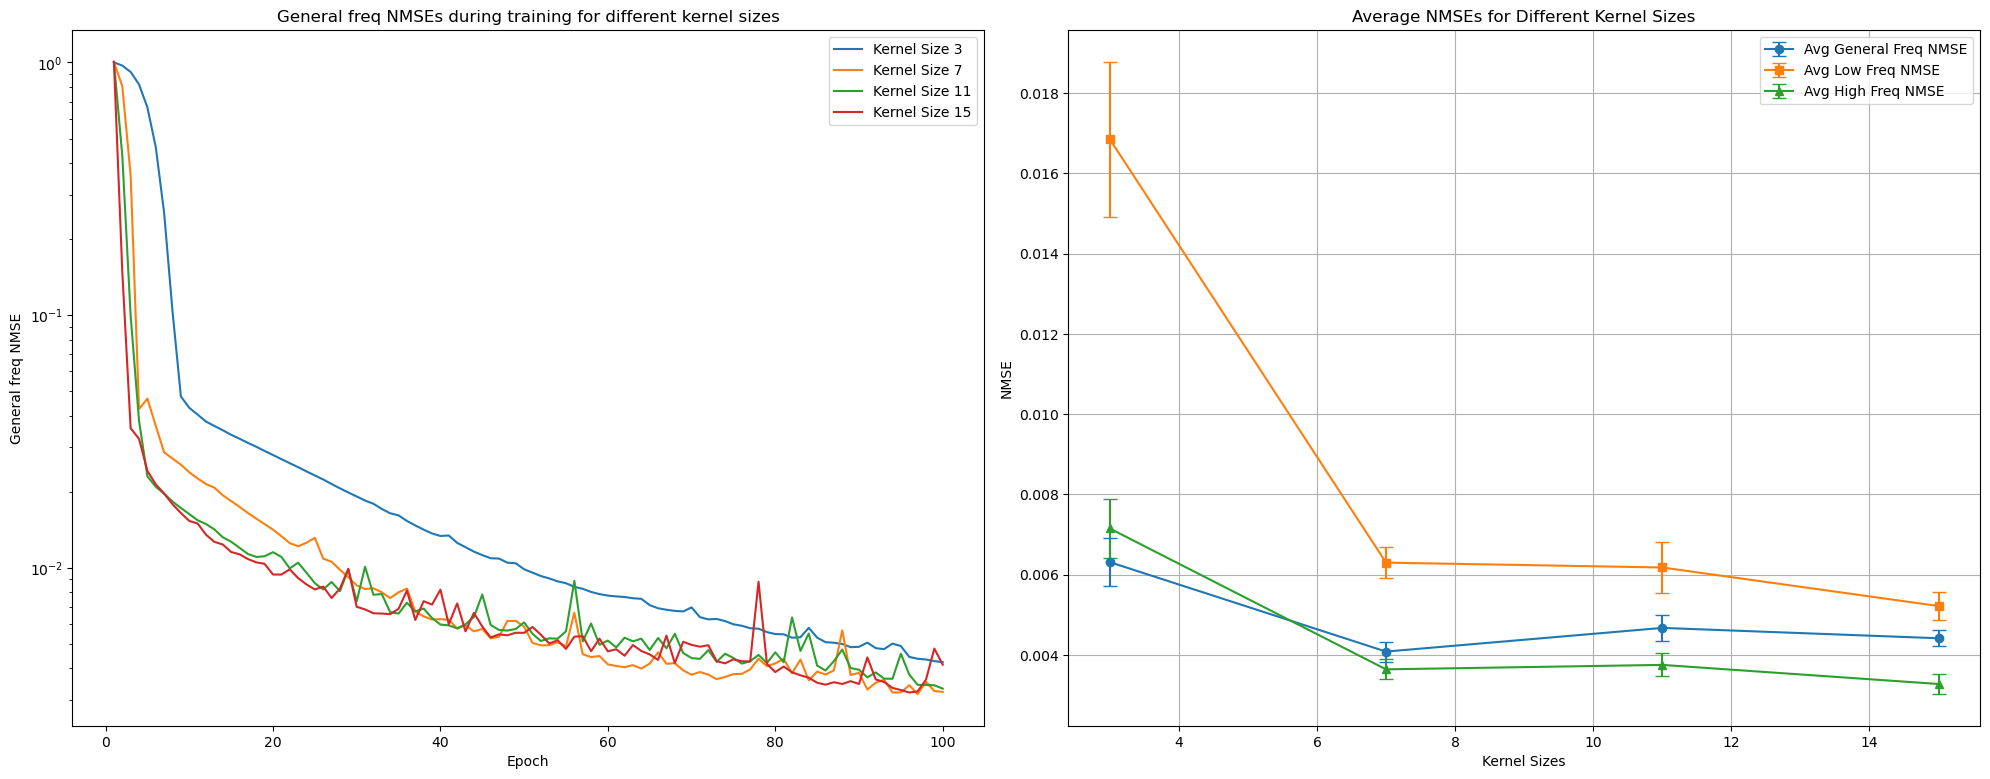

In [68]:
kernel_sizes = [3, 7, 11, 15]
seeds = [1, 2, 3]

results = run_with_multiple_seeds2(kernel_sizes, train_dataloader_g, test_dataloader_g,\
    num_epochs=100, seeds=seeds, split_freq=2,\
    filename="/home/users/erikwang/multistage/plots/spectral_bias/kernel_5runs",\
    save=True, save_model=False, order=None)